# Gridworld Experiments

This notebook fully reproduces the gridworld experiments in the paper. Namely it
1. Generates Boltzmann-rational demonstrations on the 3x3 gridworld
2. Runs PolicyWalk and PolicyWalk-HMC on this
3. Runs ValueWalk
4. Runs AVRIL and a model-based version of AVRIL (MB-AVRIL)
5. Plots the results
6. Runs PolicyWalk, PolicyWalk-HMC, and ValueWalk on a 6x6 and 12x12 gridworld to measure their running times.
7. Calculates the time per effective sample for these 3 MCMC-based methods.

In [1]:
import datetime
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro

from configuration.configurable_factory import resolve_configurable_factories
from envs.gridworld import ObservationType
from experiments.birl.presets.gridworld_presets import get_3x3_irl_gridworld_config
from experiments.birl.presets.priors import get_independent_normal_prior
from irl_algorithms.demonstrations_config import BoltzmannDemosConfig
from irl_algorithms.mcmc_irl import BayesianIRLConfig
from irl_algorithms.policy_walk import PolicyWalk, PolicyWalkRamachandran
from irl_algorithms.utils.collect_trajectories import collect_boltzmann_demos_factory_finite
from visualisation.irl import plot_demo_counts

/home/ob/venv/irl-torch/lib/python3.10/site-packages/ray/data/__init__.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources._vendor.packaging.version import parse as parse_version
/home/ob/dev/irl-torch/irl_algorithms/demonstrations_config.py:34: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @pydantic.validator("total_samples")
/home/ob/venv/irl-torch/lib/python3.10/site-packages/pydantic/_internal/_config.py:271: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydant

## 1. Generate demonstrations

In [2]:
seed = 1
beta_expert = 1.    # The Boltzmann rationality coefficient

# Set seeds in python, numpy and torch for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

env_config = get_3x3_irl_gridworld_config()
env_config.observation_type = ObservationType.index

demos_config = BoltzmannDemosConfig(
        demo_factory=collect_boltzmann_demos_factory_finite,
        total_samples=50,   # That's 50 state-action pairs
        beta_expert=beta_expert,
        append_last=False
    )

Use the configs to generate the environment:

In [3]:
resolve_configurable_factories(env_config)
env = env_config.env_factory()

map shape: (3, 3), data type: float64


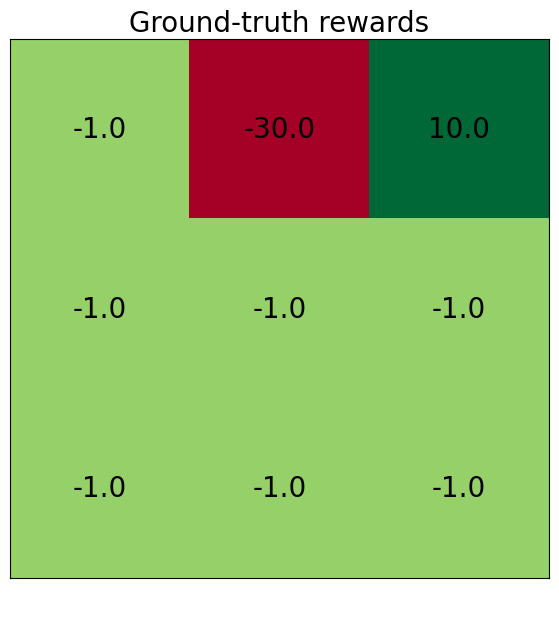

In [4]:
env.visualize_rewards(figsize=(7,7))
plt.xlabel(" ", fontsize=18)
plt.savefig("3x3_obstacle_gridworld.pdf",bbox_inches='tight')
plt.show()

map shape: (9, 9), data type: float64


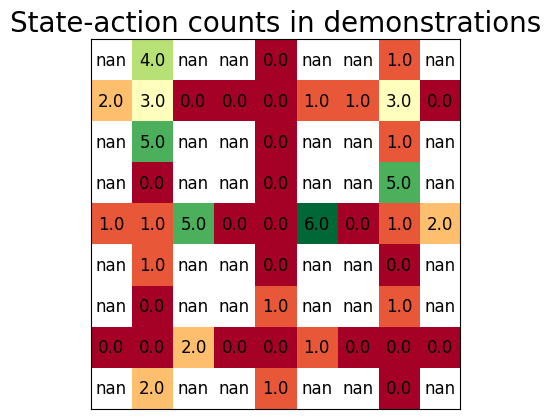

In [5]:
resolve_configurable_factories(demos_config)
D = demos_config.demo_factory(env)
plot_demo_counts(D, env, onehot=False, cell_text_fontsize=12)
plt.savefig("3x3_obstacle_gridworld_demos.pdf",bbox_inches='tight')

This shows the number of times each state-action pair appeared in the demonstrations. Each cross corresponds to the 5 actions in the given state.

## 2. Run PolicyWalk

First, we configure and then run the baseline PolicyWalk algorithm (Ramachandran and Amir 2007):

In [12]:
# Define the prior (by default, the codebase works in PyTorch, while the base PolicyWalk is implemented in NumPy and thus needs a Numpy prior):
class Normal():
        def __init__(self, size=9, scale=10.):
                self.var = scale ** 2
                self.size = size

        def log_prob(self, x):
                # Only the ratio is used in MCMC so we can drop the normalizing term
                return -0.5 * np.sum(x ** 2) / self.var
        
        def sample(self):
                return np.random.randn(self.size) * np.sqrt(self.var)
        

irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalkRamachandran,
        beta_expert=beta_expert,

        reward_prior_factory=Normal,
        prior_scale=10.,    # std of the independent normal prior on each state reward
        reward_eval_points=env_config.width * env_config.height, # Determines the dimensionality of the prior

        num_samples=1000000,

        hmc_step_size=1., # This is the highest plausibly reasonable step size, to give the baseline an avantage
)

In [13]:
resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

start_time = datetime.datetime.now()

policywalk_orig_reward_model, info = policy_walk.run(D)

policywalk_orig_runtime = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_orig_runtime} s")


PolicyWalk runtime: 0:02:50.119314 s


In [14]:
pyro.infer.mcmc.api.diagnostics({'r_s': torch.from_numpy(policywalk_orig_reward_model.param_samples)}, group_by_chain=False)

{'r_s': OrderedDict([('n_eff',
               tensor([294.7408, 783.6130, 230.1986, 464.2036, 744.6877, 393.2809, 436.2906,
                       440.3586, 832.2378], dtype=torch.float64)),
              ('r_hat',
               tensor([1.0007, 1.0060, 1.0010, 1.0007, 1.0004, 1.0009, 1.0005, 1.0006, 1.0005],
                      dtype=torch.float64))])}

### PolicyWalk-HMC

In [6]:
irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalk,
        beta_expert=beta_expert,
    
        reward_prior_factory=get_independent_normal_prior,
        prior_scale=10.,    # std of the independent normal prior on each state reward
        reward_eval_points=env_config.width * env_config.height, # Determines the dimensionality of the prior
    
        # HMC configuration
        num_samples=1000,
        warmup_steps=100,
    
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=.1,
        hmc_use_nuts=True,
        pyro_jit_compile=False # JIT does not work for PolicyWalk (runs but gives wrong results)
)

In [7]:
resolve_configurable_factories(irl_config)

In [8]:
policy_walk = irl_config.irl_method_factory(env, irl_config)

In [9]:
start_time = datetime.datetime.now()

policywalk_reward_model, info = policy_walk.run(D)

policywalk_runtime = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_runtime} s")

Sample: 100%|██████████| 1100/1100 [02:02,  8.99it/s, step size=8.35e-02, acc. prob=0.857]

PolicyWalk runtime: 0:02:02.307809 s


In [10]:
# Extract MCMC samples from the reward model:
policywalk_samples = policywalk_reward_model.param_samples

# The following can be uncommented to save/load the results instead of re-running each time:
# torch.save(policywalk_reward_model.param_samples, "vw_reward_samples.pt")
# policywalk_samples = torch.load("vw_reward_samples.pt")

In [11]:
pyro.infer.mcmc.api.diagnostics({'r_s': policywalk_reward_model.param_samples}, group_by_chain=False)

{'r_s': OrderedDict([('n_eff',
               tensor([170.9532, 184.4196, 152.2716, 258.0367, 217.1566, 234.5873, 221.4931,
                       227.3617, 257.7119])),
              ('r_hat',
               tensor([0.9994, 1.0138, 1.0022, 0.9992, 1.0016, 0.9998, 0.9992, 1.0001, 1.0021]))])}

## 3. Run ValueWalk

In [15]:
from irl_algorithms.value_walk import value_walk_tabular

irl_config = BayesianIRLConfig(
        irl_method_factory=value_walk_tabular.ValueWalkTabular,
        beta_expert=1.,
        reward_prior_factory=get_independent_normal_prior,
        num_samples=1000,
        warmup_steps=100,
        num_params=env_config.num_states - 1,
        prior_scale=10.,
        reward_eval_points=env_config.width * env_config.height,
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=0.1,
        hmc_use_nuts=True,
        pyro_jit_compile=False  # Disabled to match the PolicyWalk implementation, but can be enabled for a speedup
)
resolve_configurable_factories(irl_config)

In [16]:
value_walk = irl_config.irl_method_factory(env, irl_config)

In [17]:
start_time = datetime.datetime.now()

value_walk_reward_model, info = value_walk.run(D)

value_walk_runtime = datetime.datetime.now() - start_time
print(f"ValueWalk runtime: {value_walk_runtime} s")

Sample: 100%|██████████| 1100/1100 [00:34, 32.17it/s, step size=5.19e-01, acc. prob=0.875]

ValueWalk runtime: 0:00:34.202047 s


In [18]:
def v_s_to_r_s(v_s, P_sas, gamma=0.9):
    next_Q_sa = P_sas @ v_s # The undiscounted expected value contribution of the next state for each current state and action
    r_s = v_s - gamma * torch.max(next_Q_sa, dim=1).values
    return r_s

vw_rewards = torch.stack([v_s_to_r_s(v_s, P_sas=torch.tensor(env.P_sas[:-1, :, :-1], dtype=torch.float)) for v_s in value_walk_reward_model.param_samples])

In [19]:
value_walk_reward_model.param_samples.shape

torch.Size([1000, 9])

In [20]:
pyro.infer.mcmc.api.diagnostics({'r_s': vw_rewards}, group_by_chain=False)

{'r_s': OrderedDict([('n_eff',
               tensor([161.2141, 352.5967, 124.7994, 213.5824, 331.2974, 185.7574, 241.1940,
                       224.5423, 311.4362])),
              ('r_hat',
               tensor([1.0115, 1.0005, 1.0236, 1.0093, 0.9996, 1.0119, 1.0111, 1.0063, 1.0012]))])}

## 4. Run AVRIL

In [21]:
from irl_algorithms import avril

importlib.reload(avril)

irl_config = BayesianIRLConfig(
    irl_method_factory=avril.AVRIL,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    constraint_weight=1.,

    epochs=50000,
    svi_reporting_frequency=100,
    svi_lr=0.001,

    q_model_inputs=9,
    q_model_hidden_layer_sizes=None,
    state_only=True,
    last_state_q_penalty=10.,

    gamma=0.9,
)

resolve_configurable_factories(irl_config)


In [22]:
env_config.observation_type = ObservationType.onehot
env = env_config.env_factory()
avril_instance = irl_config.irl_method_factory(env, irl_config)

In [23]:
from irl_algorithms.demonstrations import Trajectory, Demonstrations

start_time = datetime.datetime.now()

D_onehot = Demonstrations(trajectories=[Trajectory(oa_pairs=[(torch.nn.functional.one_hot(s, num_classes=10).float(), a) for s, a in traj], truncated=traj.truncated, terminated=traj.terminated) for traj in D])
avril_reward_model, info = avril_instance.run(D_onehot)

avril_runtime = datetime.datetime.now() - start_time

Mean Reward: -202.86, Eval Time: 0:00:00.647817
Epoch: 100, Iter: 100, Train loss: 4.3198, Test Reward: -202.8600, Epoch time: 0:00:00.000645
Mean Reward: -157.02, Eval Time: 0:00:00.501431
Epoch: 200, Iter: 200, Train loss: 4.2349, Test Reward: -157.0200, Epoch time: 0:00:00.000630
Mean Reward: -56.02, Eval Time: 0:00:00.161953
Epoch: 300, Iter: 300, Train loss: 4.1721, Test Reward: -56.0200, Epoch time: 0:00:00.000628
Mean Reward: -28.74, Eval Time: 0:00:00.081635
Epoch: 400, Iter: 400, Train loss: 4.1163, Test Reward: -28.7400, Epoch time: 0:00:00.001095
Mean Reward: -33.81, Eval Time: 0:00:00.094699
Epoch: 500, Iter: 500, Train loss: 4.0668, Test Reward: -33.8100, Epoch time: 0:00:00.000647
Mean Reward: -33.74, Eval Time: 0:00:00.101065
Epoch: 600, Iter: 600, Train loss: 4.0250, Test Reward: -33.7400, Epoch time: 0:00:00.000657
Mean Reward: 2.02, Eval Time: 0:00:00.028183
Epoch: 700, Iter: 700, Train loss: 3.9858, Test Reward: 2.0200, Epoch time: 0:00:00.000632
Mean Reward: 2.75, E

## 5. Plot the results

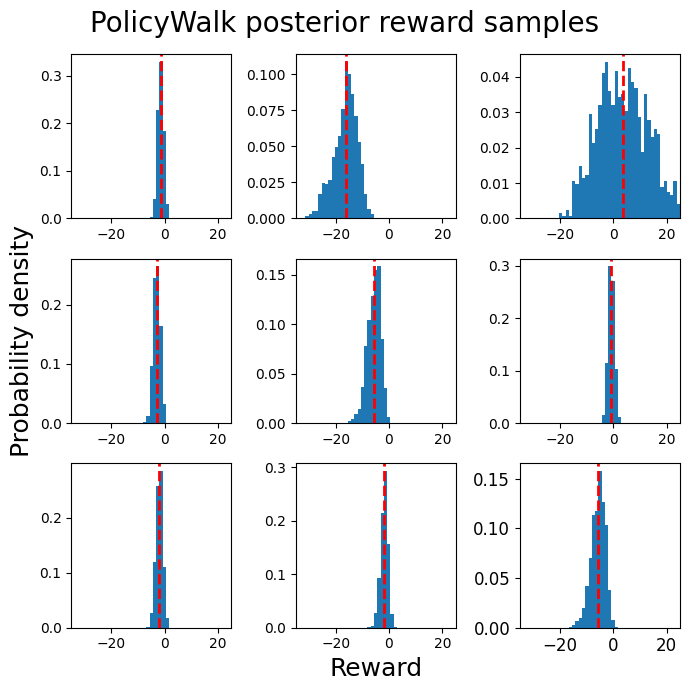

In [24]:
x_lims = (-35, 25)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)
def plot_hist_grid(samples, title="ValueWalk posterior reward samples"):
    
    # Plot with a tight layout
    
    plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        # if i ==1:
        #     plt.hist(samples[:,i].numpy(), bins=50, density=True)
        # 
        #     plt.xlim((-30,10))
        # else:
        plt.hist(samples[:,i].numpy(), bins=bins, density=True)
        # Add a vertical line representing the mean
        plt.axvline(samples[:,i].mean(), color='r', linestyle='dashed', linewidth=2)
        plt.xlim(x_lims)
        # plt.ylim(0, 0.1)
        if i == 7:
            plt.xlabel('Reward', fontsize=18)
        if i == 3:
            plt.ylabel('Probability density', fontsize=18)
    plt.tick_params(labelsize=12)
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    
plot_hist_grid(policywalk_reward_model.param_samples, title="PolicyWalk posterior reward samples")

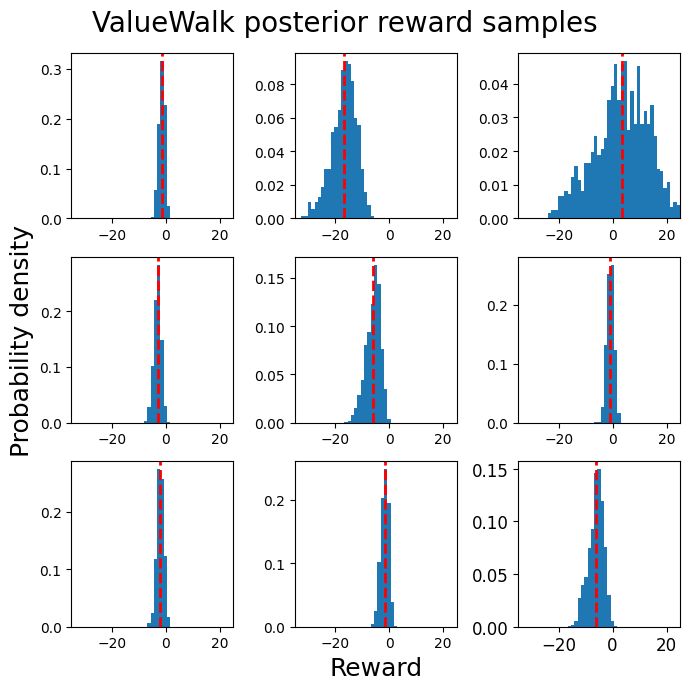

In [25]:
plot_hist_grid(vw_rewards, title="ValueWalk posterior reward samples")
plt.savefig("vw_gridworld_reward_samples.pdf", bbox_inches='tight')

In [26]:
x_lims = (-35, 25)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)

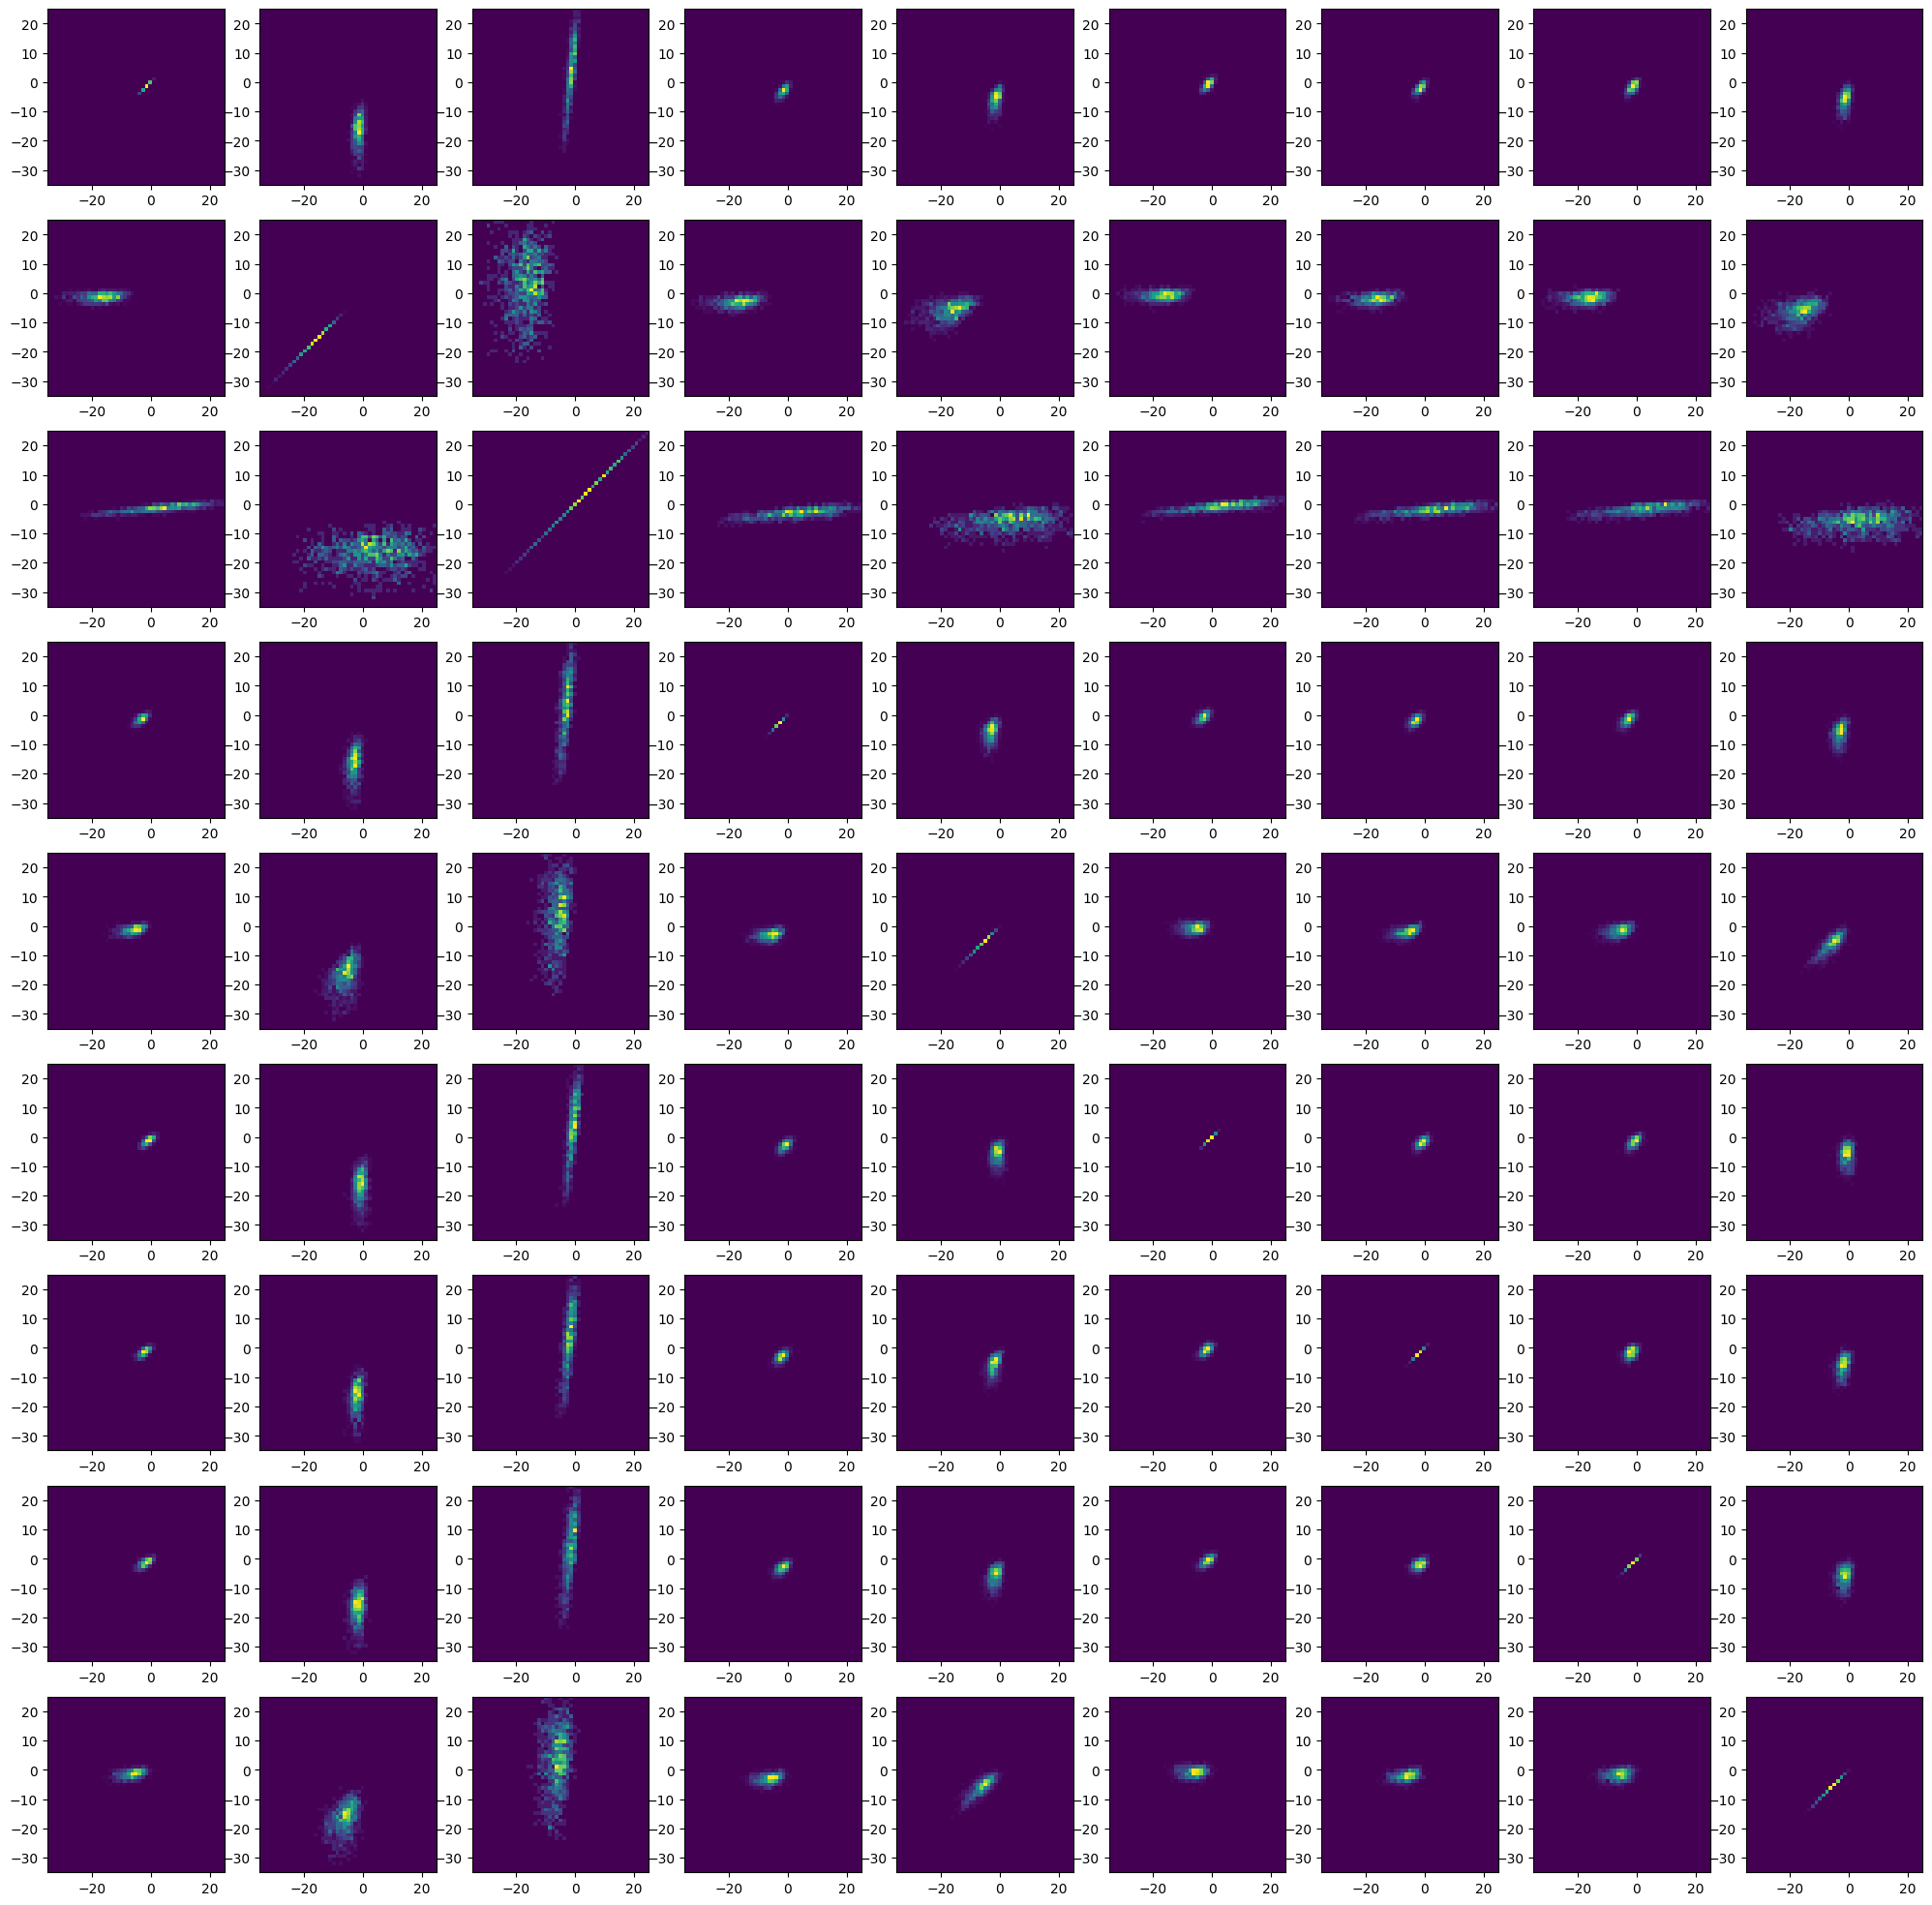

In [27]:

plt.figure(figsize=(25,25))
# plt.suptitle('Pairwise joint distributions of the 9 states in a 9x9 grid')
for i in range(9):
    for j in range(9):
        plt.subplot(9,9,9*i+j+1)
        plt.hist2d(vw_rewards[:,i].numpy(), vw_rewards[:,j].numpy(), bins=bins)
        plt.xlim(x_lims)
plt.savefig('pairwise_joint_distributions.pdf')

In [28]:
# Run multivariate Kolmogorov Smirnov test on the two reward samples
from scipy.stats import ks_2samp
for i in range(9):
    # Note that the test can be sensitive to repeated values, which occur in MCMC sampling. We therefore thin the samples by taking every 5th sample (still leaving 200 samples per dimension)
    print(ks_2samp(policywalk_reward_model.param_samples[::5,i].numpy(), vw_rewards[::5,i].numpy()))

KstestResult(statistic=0.06, pvalue=0.8655265369450457, statistic_location=-1.0902058, statistic_sign=1)
KstestResult(statistic=0.065, pvalue=0.7933622419382523, statistic_location=-18.32129, statistic_sign=-1)
KstestResult(statistic=0.06, pvalue=0.8655265369450457, statistic_location=-6.351385, statistic_sign=-1)
KstestResult(statistic=0.06, pvalue=0.8655265369450457, statistic_location=-1.6493149, statistic_sign=-1)
KstestResult(statistic=0.06, pvalue=0.8655265369450457, statistic_location=-5.8769484, statistic_sign=-1)
KstestResult(statistic=0.075, pvalue=0.6284308022715471, statistic_location=0.31689408, statistic_sign=1)
KstestResult(statistic=0.075, pvalue=0.6284308022715471, statistic_location=-3.2934682, statistic_sign=1)
KstestResult(statistic=0.07, pvalue=0.7125821300149116, statistic_location=-1.0343497, statistic_sign=1)
KstestResult(statistic=0.12, pvalue=0.11228360286766195, statistic_location=-5.024695, statistic_sign=-1)


Thus, the samples are consistent with being drawn from the same distribution.

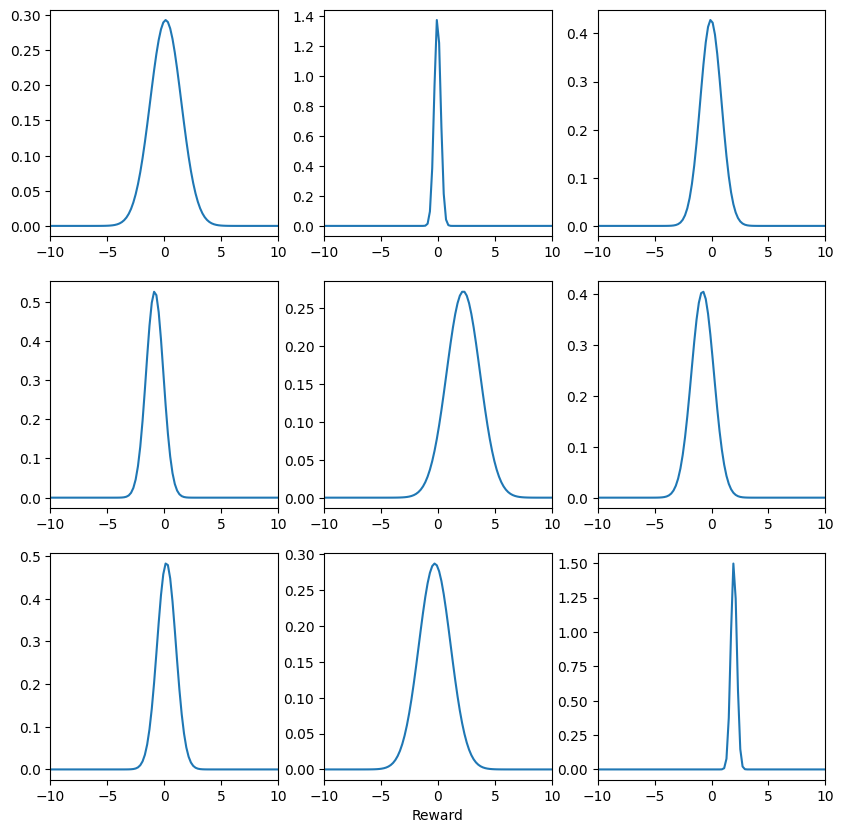

In [29]:
def plot_variational_reward_pdfs(model, x_lims=(-100, 100)):
    plt.figure(figsize=(10, 10))
    rew_model = model.reward_model
    r_plot = torch.linspace(*x_lims, 100)
    for i in range(9):
        s = torch.nn.functional.one_hot(torch.tensor(i), num_classes=10, ).float()
        plt.subplot(3, 3, i + 1)
        m, log_var = rew_model(s)
        dist = torch.distributions.Normal(m, log_var.exp().sqrt())
        plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())
        plt.xlim(x_lims)
        # plt.ylim(0, 0.8)
        if i == 7:
            plt.xlabel('Reward')


plot_variational_reward_pdfs(avril_reward_model, (-10, 10))

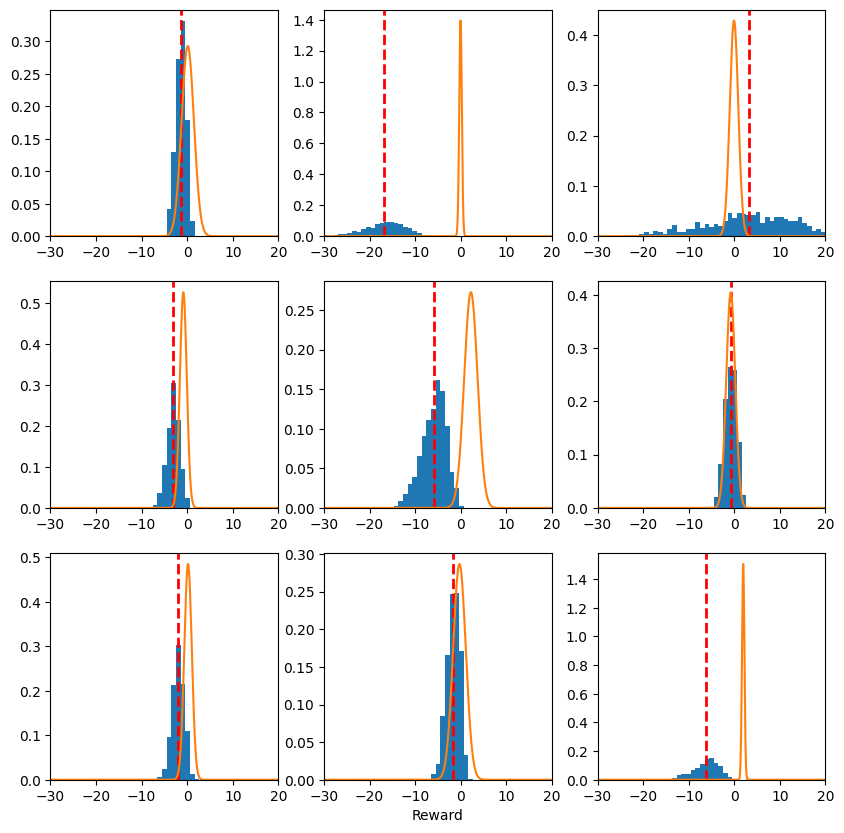

In [30]:
x_lims = (-30, 20)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)

plt.figure(figsize=(10, 10))
rew_model = avril_reward_model.reward_model
r_plot = torch.linspace(*x_lims, 1000)
for i in range(9):
    plt.subplot(3, 3, i + 1)

    plt.hist(vw_rewards[:,i].numpy(), bins=bins, density=True)
    # Add a vertical line representing the mean
    plt.axvline(vw_rewards[:,i].mean(), color='r', linestyle='dashed', linewidth=2)
    
    
    s = torch.nn.functional.one_hot(torch.tensor(i), num_classes=10, ).float()
    m, log_var = rew_model(s)
    dist = torch.distributions.Normal(m, log_var.exp().sqrt())
    plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())
    plt.xlim(x_lims)
    # plt.ylim(0, 0.8)
    if i == 7:
        plt.xlabel('Reward')


## AVRIL with TD and KL evaluation everywhere

In [31]:
from torch.distributions import Normal

P_sas = torch.tensor(env.P_sas, dtype=torch.float)


class MBAVRIL(avril.AVRIL):
    def kl(self, n_states=10):
        all_states = torch.eye(n_states)
        r_params = self.encoder(all_states)
        means = r_params[:, 0]
        log_sds = r_params[:, 1]
        kl = (self.prior_log_scale - log_sds +
                0.5 * (log_sds.exp() ** 2 + means ** 2)/self.config.prior_scale**2).mean()
        return kl

    def td_loss(self, P_sas: torch.Tensor = P_sas, n_states=10):
        all_states = torch.eye(n_states)
        r_params = self.encoder(all_states)
        means = r_params[:, 0]
        log_sds = r_params[:, 1]
        sds = torch.exp(log_sds)

        q_vals_sa = self.q_network(all_states)
        v_s = torch.max(q_vals_sa, dim=1)[0]
        vals_next_sa = P_sas @ v_s
        td = q_vals_sa - self.config.gamma * vals_next_sa
        td_loss = -Normal(means, sds).log_prob(td.T).mean()
        return td_loss
    
    def elbo(self, states_b2f: torch.Tensor, actions_b2_: torch.Tensor) -> torch.Tensor:
        q_values_ba, q_values_realized_b, q_values_next_realized_b, means_b, log_sds_b = self.q_vals_and_r_params(states_b2f, actions_b2_)

        action_logits_ba = torch.nn.functional.log_softmax(self.config.beta_expert * q_values_ba, dim=1)
        neg_log_lik = -action_logits_ba.gather(1, actions_b2_[:, :1]).mean()
                
        # The following is a hack to keep the last state Q vals at 0 (to handle the terminal state)
        last_state = torch.nn.functional.one_hot(torch.tensor(states_b2f.shape[-1]-1),
                                                 num_classes=states_b2f.shape[-1]).float()
        last_state_penalty = self.config.last_state_q_penalty * (self.q_network(last_state)**2).mean()


        return neg_log_lik + self.kl() + self.config.constraint_weight * self.td_loss() + last_state_penalty

In [32]:
irl_config = BayesianIRLConfig(
    irl_method_factory=MBAVRIL,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    constraint_weight=1.,

    epochs=20000,
    svi_reporting_frequency=100,
    svi_lr=0.001,

    q_model_inputs=9,
    q_model_hidden_layer_sizes=None,
    state_only=True,
    last_state_q_penalty=10.,

    gamma=0.9,
)
resolve_configurable_factories(irl_config)

In [33]:
mbavril = irl_config.irl_method_factory(env, irl_config)


In [34]:
start_time = datetime.datetime.now()

mbavril_reward_model, info = mbavril.run(D_onehot)

mbavril_runtime = datetime.datetime.now() - start_time


Mean Reward: -77.51, Eval Time: 0:00:00.239853
Epoch: 100, Iter: 100, Train loss: 5.0247, Test Reward: -77.5100, Epoch time: 0:00:00.000748
Mean Reward: -34.41, Eval Time: 0:00:00.091890
Epoch: 200, Iter: 200, Train loss: 4.7499, Test Reward: -34.4100, Epoch time: 0:00:00.000794
Mean Reward: -34.18, Eval Time: 0:00:00.098591
Epoch: 300, Iter: 300, Train loss: 4.6242, Test Reward: -34.1800, Epoch time: 0:00:00.000750
Mean Reward: 2.77, Eval Time: 0:00:00.018970
Epoch: 400, Iter: 400, Train loss: 4.5541, Test Reward: 2.7700, Epoch time: 0:00:00.000741
Mean Reward: 4.67, Eval Time: 0:00:00.019355
Epoch: 500, Iter: 500, Train loss: 4.5055, Test Reward: 4.6700, Epoch time: 0:00:00.000801
Mean Reward: 3.57, Eval Time: 0:00:00.019407
Epoch: 600, Iter: 600, Train loss: 4.4674, Test Reward: 3.5700, Epoch time: 0:00:00.000742
Mean Reward: 2.95, Eval Time: 0:00:00.020729
Epoch: 700, Iter: 700, Train loss: 4.4364, Test Reward: 2.9500, Epoch time: 0:00:00.000745
Mean Reward: 4.51, Eval Time: 0:00:0

In [35]:
mbavril_runtime

datetime.timedelta(seconds=20, microseconds=656104)

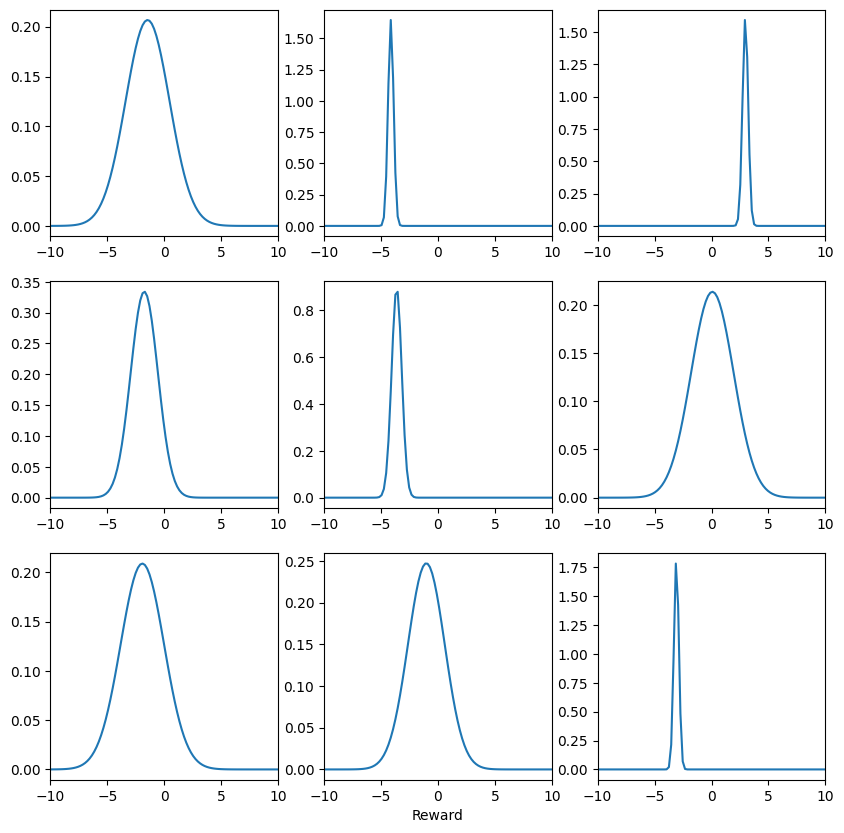

In [36]:
plot_variational_reward_pdfs(mbavril_reward_model, (-10, 10))

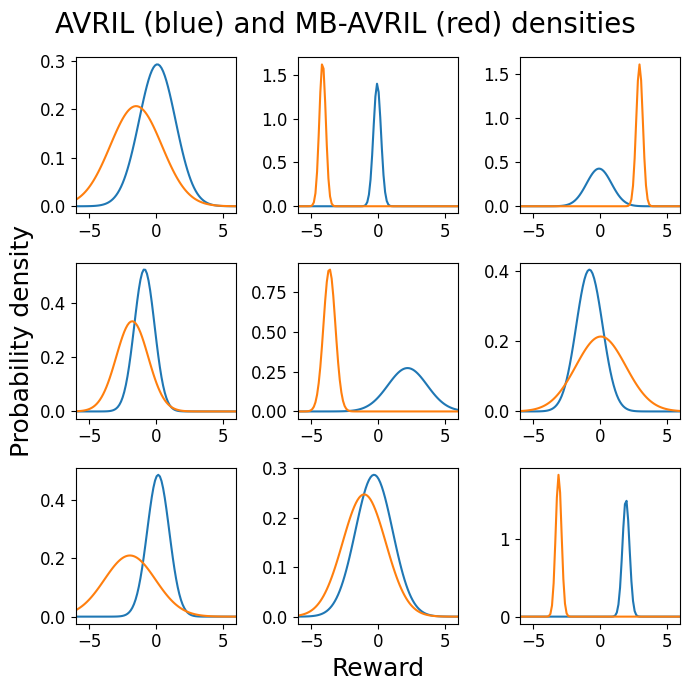

In [37]:
# Combine avril and mbavril in a single plot

x_lims = (-6, 6)

plt.figure(figsize=(7, 7))
avril_rew_model = avril_reward_model.reward_model
mbavril_rew_model = mbavril_reward_model.reward_model
r_plot = torch.linspace(*x_lims, 100)
for i in range(9):
    s = torch.nn.functional.one_hot(torch.tensor(i), num_classes=10, ).float()
    plt.subplot(3, 3, i + 1)
    m, log_var = avril_rew_model(s)
    dist = torch.distributions.Normal(m, log_var.exp().sqrt())
    plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())
    
    m, log_var = mbavril_rew_model(s)
    dist = torch.distributions.Normal(m, log_var.exp().sqrt())
    plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())

    
    plt.xlim(x_lims)
    # plt.ylim(0, 0.8)
    if i == 7:
        plt.xlabel('Reward', fontsize=18)
    if i == 3:
        plt.ylabel('Probability density', fontsize=18)
        
    # Set tick label font size for all subplots
    plt.tick_params(labelsize=12)
        

plt.suptitle("AVRIL (blue) and MB-AVRIL (red) densities", fontsize=20)
plt.tight_layout()

plt.savefig("avril_mbavril_reward_densities.pdf",bbox_inches='tight')


In [38]:
Q_sa = mbavril.q_network(torch.eye(10))

map shape: (9, 9), data type: float64


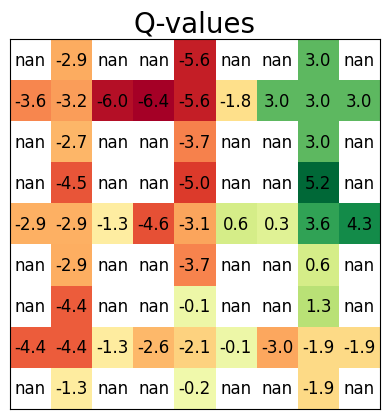

In [39]:
env.q_heatmap(Q_sa.detach().numpy(), cell_text_fontsize=12)

map shape: (9, 9), data type: float64


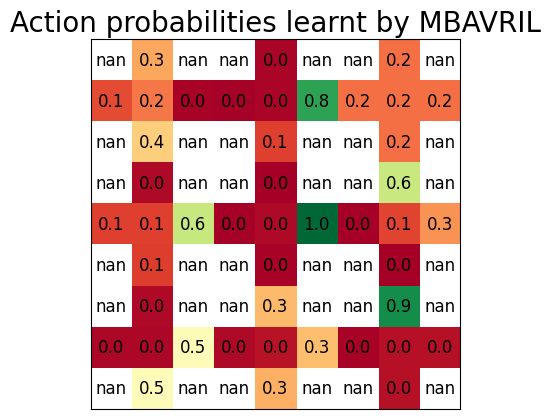

In [40]:
# Action probabilities
env.q_heatmap(torch.nn.functional.softmax(Q_sa, dim=1).detach().numpy(), title="Action probabilities learnt by MBAVRIL", cell_text_fontsize=12)

In [41]:
# List all MBAVRIL parameters
for name, param in mbavril.encoder.named_parameters():
    print(name, param)
    
for name, param in mbavril.q_network.named_parameters():
    print(name, param)

layers.weight Parameter containing:
tensor([[-0.6591, -3.3152,  3.7913, -0.9478, -2.8017,  0.8966, -1.1183, -0.2005,
         -2.2626,  0.8205],
        [ 1.7038, -2.4470, -2.4056,  0.7440, -1.2264,  1.6376,  1.6822,  1.3467,
         -2.6542, -2.4335]], requires_grad=True)
layers.bias Parameter containing:
tensor([-0.8207, -0.3893], requires_grad=True)
layers.weight Parameter containing:
tensor([[-2.6252, -5.0248,  3.5710, -2.2666, -2.4915,  4.2442, -3.7816, -1.4877,
         -1.3118,  0.6000],
        [-2.3534, -3.3348,  3.3306, -2.5182, -3.2967,  1.0052, -0.9542,  0.1704,
         -1.5517,  0.3598],
        [-5.4193, -1.2073,  3.5414, -0.6970,  1.1758,  4.8539, -0.7434,  0.4747,
         -1.3410,  0.5705],
        [-3.1843, -5.8703,  2.7250, -4.7510, -5.2621,  4.9093, -4.6111, -0.3631,
          1.0051, -0.2459],
        [-3.3701, -6.1278,  3.2252, -2.6120, -4.3490,  0.5752, -4.1271, -2.3929,
         -2.7481,  0.2543]], requires_grad=True)
layers.bias Parameter containing:
tensor([

## 6. Generate and run experiments on larger gridworlds

In [70]:
from experiments.birl.presets.gridworld_presets import get_6x6_irl_gridworld_config

seed = 1
beta_expert = 1.

# Set seeds in python, numpy and torch for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

env_config = get_6x6_irl_gridworld_config()
env_config.observation_type = ObservationType.index

demos_config = BoltzmannDemosConfig(
        demo_factory=collect_boltzmann_demos_factory_finite,
        total_samples=50,
        beta_expert=beta_expert,
        # demos_file_path=DATASET_DIR / "birl/gw_6x6_demos.pt,",
        append_last=False  # The env is now tweaked to yield an extra state at the end
    )
resolve_configurable_factories(env_config)
resolve_configurable_factories(demos_config)

env = env_config.env_factory()


In [44]:
D = demos_config.demo_factory(env)


In [45]:
irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalk,
        beta_expert=1.,
        reward_prior_factory=get_independent_normal_prior,
        num_samples=1000,
        warmup_steps=100,
        num_params=env_config.num_states - 1,
        prior_scale=10.,
        reward_eval_points=env_config.width * env_config.height,
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=.1,
        hmc_num_steps=1000,
        hmc_use_nuts=True,
        pyro_jit_compile=False
)

resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

In [46]:
start_time = datetime.datetime.now()

policywalk_reward_model_6x6, info = policy_walk.run(D)

policywalk_runtime_6x6 = datetime.datetime.now() - start_time 
print(f"PolicyWalk runtime: {policywalk_runtime_6x6} s")

Sample: 100%|██████████| 1100/1100 [16:16,  1.13it/s, step size=2.38e-02, acc. prob=0.786]

PolicyWalk runtime: 0:16:16.058768 s


In [47]:
class Normal():
        def __init__(self, size=36, scale=10.):
                self.var = scale ** 2
                self.size = size

        def log_prob(self, x):
                return -0.5 * np.sum(x ** 2) / self.var
        
        def sample(self):
                return np.random.randn(self.size) * np.sqrt(self.var)
        

irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalkRamachandran,
        beta_expert=beta_expert,

        reward_prior_factory=Normal,
        prior_scale=10.,    # std of the independent normal prior on each state reward
        reward_eval_points=env_config.width * env_config.height, # Determines the dimensionality of the prior

        num_samples=1000000,

        hmc_step_size=1., # This is the highest plausibly reasonable step size, to give the baseline an avantage
)
resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

start_time = datetime.datetime.now()

policywalk_orig_reward_model_6x6, info = policy_walk.run(D)

policywalk_runtime_vw = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_runtime.total_seconds()} s")

PolicyWalk runtime: 645.994355 s


In [48]:
from irl_algorithms.value_walk import value_walk_tabular

irl_config = BayesianIRLConfig(
    irl_method_factory=value_walk_tabular.ValueWalkTabular,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_samples=1000,
    warmup_steps=100,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    hmc_adapt_mass_matrix=False,
    hmc_adapt_step_size=True,
    hmc_step_size=0.1,
    hmc_num_steps=1000,
    hmc_use_nuts=True
)
resolve_configurable_factories(irl_config)
value_walk = irl_config.irl_method_factory(env, irl_config)

In [49]:
start_time = datetime.datetime.now()

value_walk_reward_model_6x6, info = value_walk.run(D)

value_walk_runtime_6x6 = datetime.datetime.now() - start_time
print(f"ValueWalk runtime: {value_walk_runtime_6x6} s")

Warmup:   0%|          | 0/1100 [00:00, ?it/s]/home/ob/venv/irl-torch/lib/python3.10/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 1100/1100 [00:44, 24.64it/s, step size=4.73e-01, acc. prob=0.874]

ValueWalk runtime: 0:00:44.648261 s


In [71]:
vw_rewards_6x6 = torch.stack([v_s_to_r_s(v_s, P_sas=torch.tensor(env.P_sas[:-1, :, :-1], dtype=torch.float)) for v_s in value_walk_reward_model_6x6.param_samples])

### 12x12 gridworld

In [80]:
from experiments.birl.presets.gridworld_presets import get_12x12_irl_gridworld_config

env_config = get_12x12_irl_gridworld_config()
env_config.observation_type = ObservationType.index
resolve_configurable_factories(env_config)

env = env_config.env_factory()

D = demos_config.demo_factory(env)

In [82]:
irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalk,
        beta_expert=1.,
        reward_prior_factory=get_independent_normal_prior,
        num_samples=1000,
        warmup_steps=100,
        num_params=env_config.num_states - 1,
        prior_scale=10.,
        reward_eval_points=env_config.width * env_config.height,
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=.1,
        hmc_num_steps=1000,
        hmc_use_nuts=True,

        pyro_jit_compile=False
)

resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

In [83]:
start_time = datetime.datetime.now()

policywalk_reward_model_12x12, info = policy_walk.run(D)

policywalk_runtime_12x12 = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_runtime_12x12} s")

Sample: 100%|██████████| 1100/1100 [33:56,  1.85s/it, step size=1.40e-02, acc. prob=0.845]

PolicyWalk runtime: 0:33:56.908309 s


In [53]:
class Normal():
        def __init__(self, size=144, scale=10.):
                self.var = scale ** 2
                self.size = size

        def log_prob(self, x):
                return -0.5 * np.sum(x ** 2) / self.var
        
        def sample(self):
                return np.random.randn(self.size) * np.sqrt(self.var)
        

irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalkRamachandran,
        beta_expert=beta_expert,

        reward_prior_factory=Normal,
        prior_scale=10.,    # std of the independent normal prior on each state reward
        reward_eval_points=env_config.width * env_config.height, # Determines the dimensionality of the prior

        num_samples=1000000,

        hmc_step_size=1., # This is the highest plausibly reasonable step size, to give the baseline an avantage
)
resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

start_time = datetime.datetime.now()

policywalk_orig_reward_model_12x12, info = policy_walk.run(D)

policywalk_orig_runtime_12x12 = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_orig_runtime_12x12.total_seconds()} s")

PolicyWalk runtime: 645.994355 s


In [59]:
policywalk_orig_runtime_12x12

datetime.timedelta(seconds=2465, microseconds=555265)

In [56]:
pyro.infer.mcmc.api.diagnostics({'r_s': torch.from_numpy(policywalk_orig_reward_model_12x12.param_samples)}, group_by_chain=False)

{'r_s': OrderedDict([('n_eff',
               tensor([ 30.7347,  34.0789,  31.2394,  24.8265,  27.7298,  24.4461,  27.5715,
                        27.4246,  24.4437,  40.7238,  46.7112,  17.1836,  60.2567,  43.8966,
                        35.6539,  20.3237,  32.3755,  34.0887,  37.3681,  51.8937,  38.3430,
                        61.3945, 122.3165,  46.1200,  59.9767,  41.2034,  35.3232,  71.4112,
                        41.9399,  11.5511,  37.4417,  39.5176,  33.5818,  32.9159,  35.9948,
                       124.2492,  29.4508,  92.8037,  38.3307,  30.1941,  26.7290,  21.3163,
                        35.7532,  26.2804,  22.2278,  45.7878,  52.0712,  26.1837,  38.5498,
                        59.2673,  37.7771,  36.1914,  34.8178,  34.9127,  27.6801,  25.8915,
                        56.1286,  30.7560,  30.1527,  39.8863,  26.2722,  74.5599,  41.7196,
                        35.7062, 117.1476,  43.8323,  15.7180,  43.3650,  99.4049,  31.6335,
                        27.6691,  41.32

In [54]:
irl_config = BayesianIRLConfig(
    irl_method_factory=value_walk_tabular.ValueWalkTabular,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_samples=1000,
    warmup_steps=100,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    hmc_adapt_mass_matrix=False,
    hmc_adapt_step_size=True,
    hmc_step_size=0.1,
    hmc_use_nuts=True
)
resolve_configurable_factories(irl_config)
value_walk = irl_config.irl_method_factory(env, irl_config)
start_time = datetime.datetime.now()

value_walk_reward_model_12x12, info = value_walk.run(D)

value_walk_runtime_12x12 = datetime.datetime.now() - start_time
print(f"ValueWalk runtime: {value_walk_runtime_12x12} s")

Warmup:   0%|          | 0/1100 [00:00, ?it/s]/home/ob/venv/irl-torch/lib/python3.10/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 1100/1100 [00:56, 19.55it/s, step size=5.37e-01, acc. prob=0.849]

ValueWalk runtime: 0:00:56.275706 s


In [69]:
vw_rewards_12x12 = torch.stack([v_s_to_r_s(v_s, P_sas=torch.tensor(env.P_sas[:-1, :, :-1], dtype=torch.float)) for v_s in value_walk_reward_model_12x12.param_samples])

In [68]:
len(vw_rewards_12x12)

1000

### Speed comparison table

We gather the results in a single dataframe. In particular, we use the MCMC reward samples to calculate the effective sample size (this is calculated per dimension, and then we take the minimum across dimensions) and then divide this by the total time taken to run the algorithm. Note that for all three models, the first 10% of samples were discarded as a warm-up, and the time to generate those warm-up samples is included in the total time since warm-up is an integral part of the sampling procedure. We then divide the total time by the effective samples to obtain the time per effective sample reported in the paper.

In [94]:
import pandas as pd

speed_df = pd.DataFrame({
    'gw_size': [9, 36, 144],
    
    'pw_orig_total_time': [policywalk_orig_runtime.total_seconds(), 646, policywalk_orig_runtime_12x12.total_seconds()],  # The last two values are copied from the values printed above
    'pw_hmc_total_time': [policywalk_runtime.total_seconds(), 16*60+16, policywalk_runtime_12x12.total_seconds()],
    'vw_total_time': [value_walk_runtime.total_seconds(), value_walk_runtime_6x6.total_seconds(), value_walk_runtime_12x12.total_seconds()],

    'pw_orig_ess': [
        pyro.infer.mcmc.api.diagnostics({'r_s': torch.from_numpy(policywalk_orig_reward_model.param_samples[1000:])}, group_by_chain=False)['r_s']['n_eff'].min().item(),
        pyro.infer.mcmc.api.diagnostics({'r_s': torch.from_numpy(policywalk_orig_reward_model_6x6.param_samples[1000:])}, group_by_chain=False)['r_s']['n_eff'].min().item(),
        pyro.infer.mcmc.api.diagnostics({'r_s': torch.from_numpy(policywalk_orig_reward_model_12x12.param_samples[1000:])}, group_by_chain=False)['r_s']['n_eff'].min().item()
    ],
    'pw_hmc_ess': [
        pyro.infer.mcmc.api.diagnostics({'r_s': policywalk_reward_model.param_samples}, group_by_chain=False)['r_s']['n_eff'].min().item(),
        pyro.infer.mcmc.api.diagnostics({'r_s': policywalk_reward_model_6x6.param_samples}, group_by_chain=False)['r_s']['n_eff'].min().item(),
        pyro.infer.mcmc.api.diagnostics({'r_s': policywalk_reward_model_12x12.param_samples}, group_by_chain=False)['r_s']['n_eff'].min().item()],
    'vw_ess': [
        pyro.infer.mcmc.api.diagnostics({'r_s': vw_rewards}, group_by_chain=False)['r_s']['n_eff'].min().item(),
        pyro.infer.mcmc.api.diagnostics({'r_s': vw_rewards_6x6}, group_by_chain=False)['r_s']['n_eff'].min().item(),
        pyro.infer.mcmc.api.diagnostics({'r_s': vw_rewards_12x12}, group_by_chain=False)['r_s']['n_eff'].min().item()]
    
})
speed_df

,gw_size,pw_orig_total_time,pw_hmc_total_time,vw_total_time,pw_orig_ess,pw_hmc_ess,vw_ess
0,9,170.119314,122.307809,34.202047,197.947082,152.271576,124.799362
1,36,646.000000,976.000000,44.648261,71.758102,233.307693,62.683201
2,144,2465.555265,2036.908309,56.275706,10.005133,110.472733,73.476578


In [95]:
speed_df["vw_s_per_eff_sample"] =  speed_df["vw_total_time"] / speed_df["vw_ess"]
speed_df["pw_orig_s_per_eff_sample"] =  speed_df["pw_orig_total_time"] / speed_df["pw_orig_ess"]
speed_df["pw_hmc_s_per_eff_sample"] =  speed_df["pw_hmc_total_time"] / speed_df["pw_hmc_ess"] 


In [96]:
speed_df

,gw_size,pw_orig_total_time,pw_hmc_total_time,vw_total_time,pw_orig_ess,pw_hmc_ess,vw_ess,vw_s_per_eff_sample,pw_orig_s_per_eff_sample,pw_hmc_s_per_eff_sample
0,9,170.119314,122.307809,34.202047,197.947082,152.271576,124.799362,0.274056,0.859418,0.803222
1,36,646.000000,976.000000,44.648261,71.758102,233.307693,62.683201,0.712284,9.002468,4.183317
2,144,2465.555265,2036.908309,56.275706,10.005133,110.472733,73.476578,0.765900,246.429043,18.438109
